In [1]:
%matplotlib inline
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy
import scipy
import statsmodels.tsa.seasonal as decomp

# North Atlantic Timeseries

In [2]:
# Load multiyear dataset and create basin-wide time series
ssts = xr.open_dataset("sst_data/sst.day.mean.1982-2024.na.nc")
ssts = ssts.sel(lat=slice(0, 60), lon=slice(-80,0)).load()
ssts.attrs["long_name"] = "SST Anomaly ($^\circ$C)"
avg_ssts = ssts.mean(["lat","lon"])

<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/354354898.py:4: SyntaxWarning: invalid escape sequence '\c'
  ssts.attrs["long_name"] = "SST Anomaly ($^\circ$C)"


In [3]:
# Played around with detrending using global mean SSTs - not particularly relevant
"""globe = xr.open_mfdataset("/vast/clidex/data/obs/SST/OISST/OISSTv2.1/sst.day.mean.????.nc")
globe.coords['lon'] = (globe.coords['lon'] + 180) % 360 - 180
globe = globe.sortby(globe.lon)
ssts_globe = globe[["sst"]].load()
ssts_globe_monthly = ssts_globe.sst.groupby("time.month")
global_ts = ssts_globe_monthly - ssts_globe.sel(time=slice("1991-01-01", "2020-01-01")).sst.groupby("time.month").mean(dim="time")
global_ts.to_netcdf(path="sst_data/sst.monthly.mean.1982-2024.ts.nc")"""

'globe = xr.open_mfdataset("/vast/clidex/data/obs/SST/OISST/OISSTv2.1/sst.day.mean.????.nc")\nglobe.coords[\'lon\'] = (globe.coords[\'lon\'] + 180) % 360 - 180\nglobe = globe.sortby(globe.lon)\nssts_globe = globe[["sst"]].load()\nssts_globe_monthly = ssts_globe.sst.groupby("time.month")\nglobal_ts = ssts_globe_monthly - ssts_globe.sel(time=slice("1991-01-01", "2020-01-01")).sst.groupby("time.month").mean(dim="time")\nglobal_ts.to_netcdf(path="sst_data/sst.monthly.mean.1982-2024.ts.nc")'

In [4]:
# An extension of the previous cell - takes FOREVER to run, might want to comment this and related lines out
global_ts = xr.load_dataset("sst_data/sst.monthly.mean.1982-2024.ts.nc")
avg_global_ts = global_ts.mean(["lat","lon"])

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/1138575633.py:3: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('SST Anomaly ($^\circ$C)')


Text(0, 0.5, 'SST Anomaly ($^\\circ$C)')

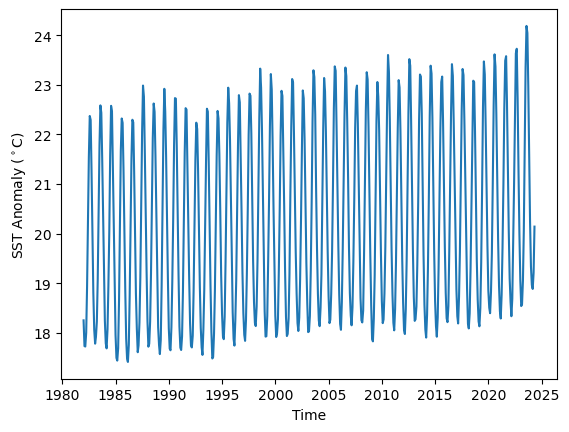

In [5]:
# Create time series of monthly mean North Atlantic basin SSTs
avg_ssts.sst.resample(time="1MS").mean(dim="time").plot()
plt.ylabel('SST Anomaly ($^\circ$C)')

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/3351166807.py:3: SyntaxWarning: invalid escape sequence '\c'
  plt.ylabel('SST Anomaly ($^\circ$C)')


Text(0, 0.5, 'SST Anomaly ($^\\circ$C)')

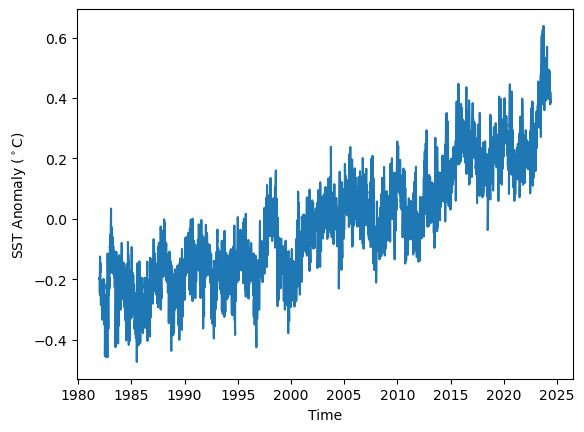

In [6]:
# Time series of global mean SSTs
avg_global_ts.sst.plot()
plt.ylabel('SST Anomaly ($^\circ$C)')

In [7]:
# Using 1991 to 2020 climatology 
climatology = ssts.sel(time=slice("1991-01-01", "2021-01-01"))
seasonal_clim = climatology.sst.groupby("time.month").mean(dim="time")
ssts_monthly = ssts.sst.groupby("time.month")
# Remove seasonal cycle and create 12 month rolling mean
ssts_no_seas = ssts_monthly - seasonal_clim
avg_ssts_ts = ssts_no_seas.mean(["lat","lon"])
avg_ssts_monthly = avg_ssts_ts.resample(time="1MS").mean(dim="time")
rolling_ssts_monthly = avg_ssts_monthly.rolling(time=12, center=True).mean("time")
# remove warming trend and create 12 month rolling mean
dtrnd_ssts_monthly = avg_ssts_monthly - avg_global_ts.resample(time="1MS").mean(dim="time")
dtrnd_rolling_monthly = dtrnd_ssts_monthly.rolling(time=12, center=True).mean("time")

In [8]:
rolling_ssts_monthly = avg_ssts_monthly.rolling(time=12, center=True).mean("time")
dtrnd_rolling_monthly = dtrnd_ssts_monthly.rolling(time=12, center=True).mean("time")

<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/391690844.py:6: SyntaxWarning: invalid escape sequence '\c'
  ax1a.set_ylabel('SST Anomaly ($^\circ$C)')


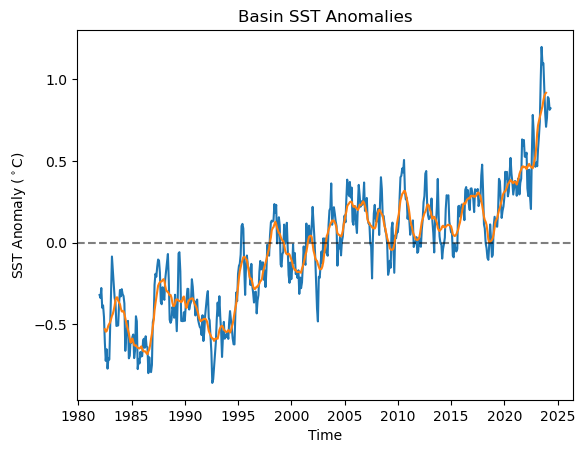

In [9]:
# Plot monthly mean basin SSTs and 12 month rolling mean
fig1a, ax1a = plt.subplots()
avg_ssts_monthly.resample(time="1MS").mean(dim="time").plot(ax=ax1a)
rolling_ssts_monthly.plot(ax=ax1a)
plt.axhline(y=0, color="black", linestyle = "dashed", alpha = 0.5)
ax1a.set_ylabel('SST Anomaly ($^\circ$C)')
plt.title("Basin SST Anomalies")
plt.savefig("figures/NA_ts.png", dpi=300)

<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/2016012972.py:6: SyntaxWarning: invalid escape sequence '\c'
  ax1b.set_ylabel('SST Anomaly ($^\circ$C)')


Text(0, 0.5, 'SST Anomaly ($^\\circ$C)')

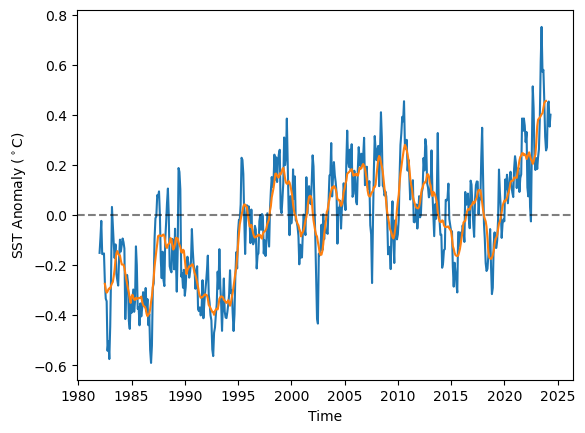

In [10]:
# Time series with global mean SSTs subtracted; orange is 12 month rolling mean
fig1b, ax1b = plt.subplots()
dtrnd_ssts_monthly.sst.plot(ax=ax1b)
dtrnd_rolling_monthly.sst.plot(ax=ax1b)
plt.axhline(y=0, color="black", linestyle = "dashed", alpha = 0.5)
ax1b.set_ylabel('SST Anomaly ($^\circ$C)')

# NAO Index

In [11]:
# Code to pull and turn NAO index into a nice NetCDF file - maybe this is unnecessary, but it makes everything
# a bit nicer to work with. Data from https://psl.noaa.gov/data/climateindices/list/ .
'''nao = pd.read_csv("sst_data/nao_raw.txt", names=["Time"])
nao = nao['Time'].str.split(expand=True)
nao.columns = ['Time', '1', '2', '3','4','5','6','7','8','9','10','11','12']
# The following line gives a DataFrame containing NAO indicies for 1950-2023; line 77 is incomplete (2024), may want to include this
nao = nao.drop([0, 1, 2, 78, 79, 80])
nao = nao.melt(id_vars=['Time'], value_vars=['1', '2', '3','4','5','6','7','8','9','10','11','12'], var_name="Month")
nao["Time"] = pd.to_datetime(nao['Time'] + nao['Month'], format="%Y%m")
nao["value"] = pd.to_numeric(nao["value"])
nao = nao.sort_values(by="Time")
nao = nao.reset_index()
nao = nao.drop(columns=['index', "Month"])
mask = nao["value"] == -99.90
nao = nao[~mask]
nao_nc = xr.DataArray(nao["value"], coords=[nao["Time"]], name="index")
nao_nc = nao_nc.rename({"dim_0":"time"})
nao_nc.to_netcdf("sst_data/nao.nc")
#nao = nao.groupby(nao["Time"].dt.year)["value"].mean()'''

'nao = pd.read_csv("sst_data/nao_raw.txt", names=["Time"])\nnao = nao[\'Time\'].str.split(expand=True)\nnao.columns = [\'Time\', \'1\', \'2\', \'3\',\'4\',\'5\',\'6\',\'7\',\'8\',\'9\',\'10\',\'11\',\'12\']\n# The following line gives a DataFrame containing NAO indicies for 1950-2023; line 77 is incomplete (2024), may want to include this\nnao = nao.drop([0, 1, 2, 78, 79, 80])\nnao = nao.melt(id_vars=[\'Time\'], value_vars=[\'1\', \'2\', \'3\',\'4\',\'5\',\'6\',\'7\',\'8\',\'9\',\'10\',\'11\',\'12\'], var_name="Month")\nnao["Time"] = pd.to_datetime(nao[\'Time\'] + nao[\'Month\'], format="%Y%m")\nnao["value"] = pd.to_numeric(nao["value"])\nnao = nao.sort_values(by="Time")\nnao = nao.reset_index()\nnao = nao.drop(columns=[\'index\', "Month"])\nmask = nao["value"] == -99.90\nnao = nao[~mask]\nnao_nc = xr.DataArray(nao["value"], coords=[nao["Time"]], name="index")\nnao_nc = nao_nc.rename({"dim_0":"time"})\nnao_nc.to_netcdf("sst_data/nao.nc")\n#nao = nao.groupby(nao["Time"].dt.year)["value"

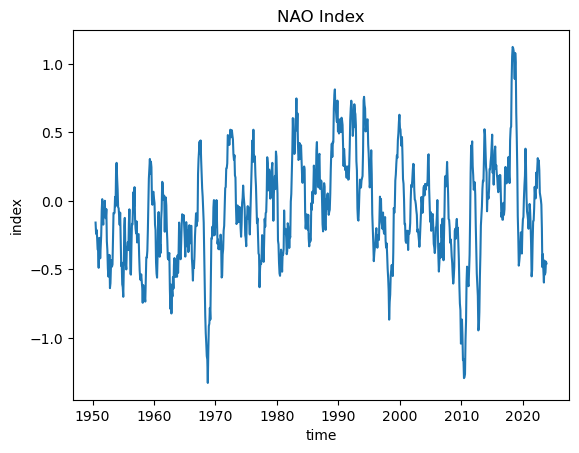

In [12]:
nao = xr.load_dataarray("sst_data/nao.nc")
# 12 month rolling mean of NAO index
nao_smooth = nao.rolling(time=12, center=True).mean("time")
nao_smooth.plot()
plt.title("NAO Index")
plt.savefig("figures/nao.png", dpi=300)

# Box of Boxes

## Definitions
Using the smoothed basin-wide time series from the previous section, I identified a warm period (2020 through 2023) and cold period (1990 through 1994). Then, I averaged and plotted the basin-wide SST anomalies for these periods alongside average SST anomalies for 2023 (falls well within warm period) and 1992 (again, falls well in cold period). I defined four 5$^\circ$ by 5$^\circ$ boxes in regions displaying temporal variability that could be used for later analyses. [Note to future self - larger boxes may make time series less noisy]

<>:13: SyntaxWarning: invalid escape sequence '\c'
<>:13: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/3132158790.py:13: SyntaxWarning: invalid escape sequence '\c'
  three_yr_avg_cool.plot(ax=ax2, cmap = "seismic", transform = ccrs.PlateCarree(), vmin = -1, vmax = 0.2, cbar_kwargs={'shrink': 0.6, "aspect":30, 'label':'SST Anomaly ($^\circ$C)'})


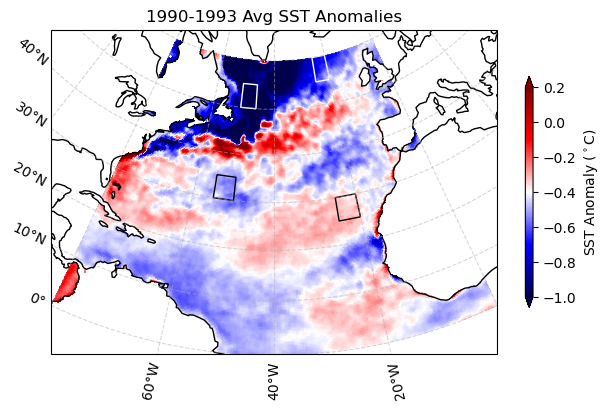

In [13]:
central_lon = -40
central_lat = 30
# Grab cold period data
three_yr_avg_cool = ssts_no_seas.sel(time=slice("1990-01-01","1994-01-01")).mean(dim="time")
# Plot and add boxes
fig2, ax2 = plt.subplots(subplot_kw={'projection': ccrs.LambertConformal(central_lon, central_lat)}, figsize=(7.2, 5))
ax2.coastlines()
ax2.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor="none")
gl = ax2.gridlines(alpha = 0.5, linestyle = "--", draw_labels=True, x_inline=False, y_inline=False)
gl.right_labels = False
gl.top_labels = False
ax2.set_extent([-80, 0, 0, 60])
three_yr_avg_cool.plot(ax=ax2, cmap = "seismic", transform = ccrs.PlateCarree(), vmin = -1, vmax = 0.2, cbar_kwargs={'shrink': 0.6, "aspect":30, 'label':'SST Anomaly ($^\circ$C)'})
ax2.add_patch(mpatches.Rectangle(xy=[-51, 50], width = 5, height = 5, alpha=1, facecolor="none", ec="white", transform=ccrs.PlateCarree()))
ax2.add_patch(mpatches.Rectangle(xy=[-20, 60], width = -5, height = -5, alpha=1, facecolor="none", ec="white", transform=ccrs.PlateCarree()))
ax2.add_patch(mpatches.Rectangle(xy=[-55, 30], width = 5, height = 5, alpha=1, facecolor="none", ec="black", transform=ccrs.PlateCarree()))
ax2.add_patch(mpatches.Rectangle(xy=[-25, 25], width = 5, height = 5, alpha=1, facecolor="none", ec="black", transform=ccrs.PlateCarree()))
plt.title("1990-1993 Avg SST Anomalies")
plt.savefig("figures/cool_stretch_ssts.png", dpi=300)

<>:11: SyntaxWarning: invalid escape sequence '\c'
<>:11: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/3715096728.py:11: SyntaxWarning: invalid escape sequence '\c'
  three_yr_avg_warm.plot(ax=ax4, cmap = "seismic", transform = ccrs.PlateCarree(), vmin=-0.2, vmax=1, cbar_kwargs={'shrink': 0.6, "aspect":30, 'label':'SST Anomaly ($^\circ$C)'})


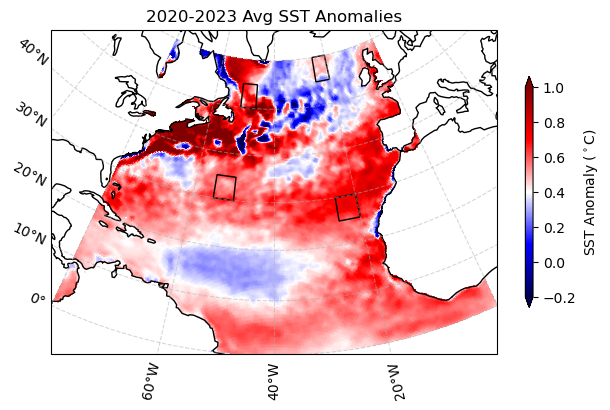

In [14]:
# Grab warm period data
three_yr_avg_warm = ssts_no_seas.sel(time=slice("2020-01-01","2024-01-01")).mean(dim="time")
# Plot and add boxes
fig4, ax4 = plt.subplots(subplot_kw={'projection': ccrs.LambertConformal(central_lon, central_lat)}, figsize=(7.2, 5))
ax4.coastlines()
ax4.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor="none")
gl = ax4.gridlines(alpha = 0.5, linestyle = "--", draw_labels=True, y_inline=False, x_inline=False)
gl.right_labels = False
gl.top_labels = False
ax4.set_extent([-80, 0, 0, 60])
three_yr_avg_warm.plot(ax=ax4, cmap = "seismic", transform = ccrs.PlateCarree(), vmin=-0.2, vmax=1, cbar_kwargs={'shrink': 0.6, "aspect":30, 'label':'SST Anomaly ($^\circ$C)'})
ax4.add_patch(mpatches.Rectangle(xy=[-51, 50], width = 5, height = 5, alpha=1, facecolor="none", ec="black", transform=ccrs.PlateCarree()))
ax4.add_patch(mpatches.Rectangle(xy=[-25, 55], width = 5, height = 5, alpha=1, facecolor="none", ec="black", transform=ccrs.PlateCarree()))
ax4.add_patch(mpatches.Rectangle(xy=[-55, 30], width = 5, height = 5, alpha=1, facecolor="none", ec="black", transform=ccrs.PlateCarree()))
ax4.add_patch(mpatches.Rectangle(xy=[-25, 25], width = 5, height = 5, alpha=1, facecolor="none", ec="black", transform=ccrs.PlateCarree()))
plt.title("2020-2023 Avg SST Anomalies")
plt.savefig("figures/warm_stretch_ssts.png", dpi=300)

<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/2442126097.py:7: SyntaxWarning: invalid escape sequence '\c'
  yr_avg_cool.plot(ax=ax3, cmap = "seismic", transform = ccrs.PlateCarree(), vmin = -2, vmax =0.7, cbar_kwargs={'shrink': 0.8, 'label':'SST Anomaly ($^\circ$C)'})


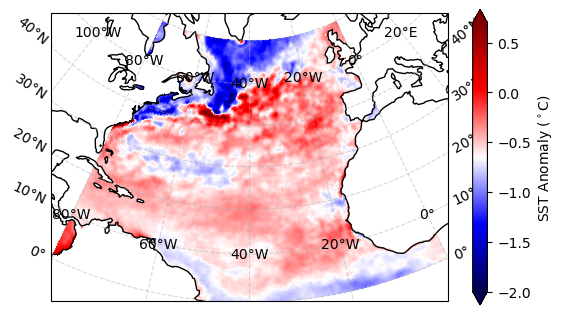

In [15]:
yr_avg_cool = ssts_no_seas.sel(time=slice("1992-01-01","1993-01-01")).mean(dim="time")
fig3, ax3 = plt.subplots(subplot_kw={'projection': ccrs.LambertConformal(central_lon, central_lat)})
ax3.coastlines()
ax3.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor="none")
gl = ax3.gridlines(alpha = 0.5, linestyle = "--", draw_labels=True)
ax3.set_extent([-80, 0, 0, 60])
yr_avg_cool.plot(ax=ax3, cmap = "seismic", transform = ccrs.PlateCarree(), vmin = -2, vmax =0.7, cbar_kwargs={'shrink': 0.8, 'label':'SST Anomaly ($^\circ$C)'})

<>:7: SyntaxWarning: invalid escape sequence '\c'
<>:7: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/1726140369.py:7: SyntaxWarning: invalid escape sequence '\c'
  yr_avg_warm.plot(ax=ax5, cmap = "seismic", transform = ccrs.PlateCarree(), vmin = -0.7, vmax =2, cbar_kwargs={'shrink': 0.8, 'label':'SST Anomaly ($^\circ$C)'})


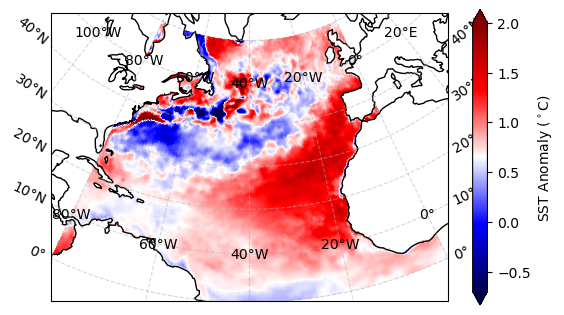

In [16]:
yr_avg_warm = ssts_no_seas.sel(time=slice("2023-01-01","2024-01-01")).mean(dim="time")
fig5, ax5 = plt.subplots(subplot_kw={'projection': ccrs.LambertConformal(central_lon, central_lat)})
ax5.coastlines()
ax5.add_feature(cartopy.feature.LAKES, edgecolor='black', facecolor="none")
gl = ax5.gridlines(alpha = 0.5, linestyle = "--", draw_labels=True)
ax5.set_extent([-80, 0, 0, 60])
yr_avg_warm.plot(ax=ax5, cmap = "seismic", transform = ccrs.PlateCarree(), vmin = -0.7, vmax =2, cbar_kwargs={'shrink': 0.8, 'label':'SST Anomaly ($^\circ$C)'})

## Analysis

<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:20: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/1646384162.py:20: SyntaxWarning: invalid escape sequence '\c'
  ax6.set_ylabel('SST Anomaly ($^\circ$C)')


Text(0, 0.5, 'SST Anomaly ($^\\circ$C)')

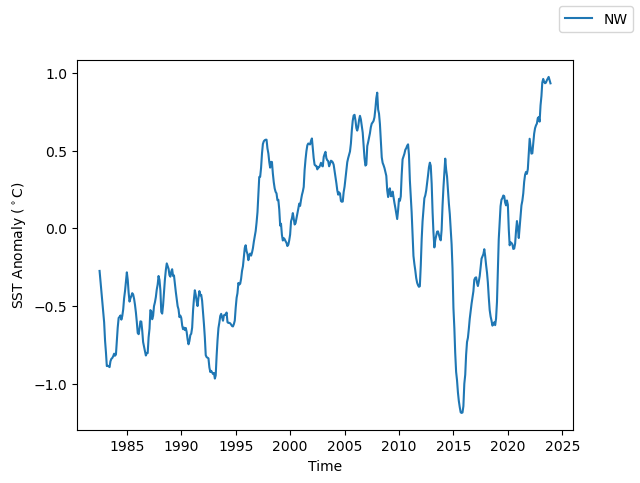

In [17]:
# Create monthly averages for each box
nw = ssts_no_seas.sel(lon=slice(-25,-20), lat=slice(55, 60)).resample(time="1MS").mean(dim='time')
ne = ssts_no_seas.sel(lon=slice(-51,-46), lat=slice(50, 55)).resample(time="1MS").mean(dim='time')
sw = ssts_no_seas.sel(lon=slice(-55,-50), lat=slice(30, 35)).resample(time="1MS").mean(dim='time')
se = ssts_no_seas.sel(lon=slice(-25,-20), lat=slice(25, 30)).resample(time="1MS").mean(dim='time')

# Create 12-month rolling means
nw_roll = nw.mean(['lat','lon']).rolling(time=12, center=True).mean('time')
ne_roll = ne.mean(['lat','lon']).rolling(time=12, center=True).mean('time')
sw_roll = sw.mean(['lat','lon']).rolling(time=12, center=True).mean('time')
se_roll = se.mean(['lat','lon']).rolling(time=12, center=True).mean('time')

# Plot timeseries
fig6, ax6 = plt.subplots()
nw_roll.plot(ax=ax6, label = "NW")
#ne_roll.plot(ax=ax6, label = "NE")
#sw_roll.plot(ax=ax6, label = "SW")
#se_roll.plot(ax=ax6, label = "SE")
fig6.legend()
ax6.set_ylabel('SST Anomaly ($^\circ$C)')

## Histograms
Create histograms using smoothed monthly mean time series for each box.

<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/2177503525.py:6: SyntaxWarning: invalid escape sequence '\c'
  nw_ax.set_xlabel('SST Anomaly ($^\circ$C)')


Text(0.5, 0, 'SST Anomaly ($^\\circ$C)')

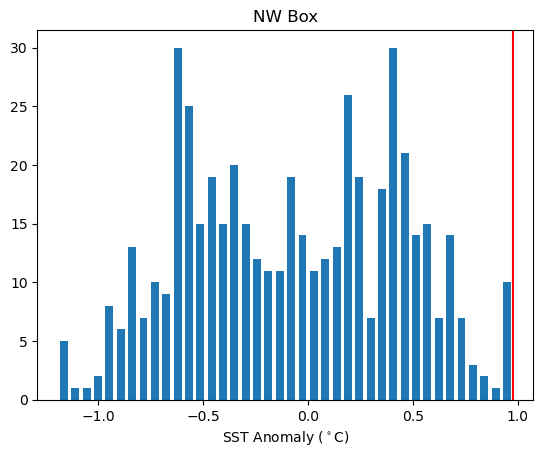

In [18]:
nw_plt, nw_ax = plt.subplots()
nw_roll.plot.hist(ax=nw_ax, bins=40, rwidth=0.7)
nw_ax.set_title("NW Box")
# red line represents 2020-2023 max anomaly
nw_ax.axvline(nw_roll.sel(time=slice("2020-01-01","2024-01-01")).max(), color = "red")
nw_ax.set_xlabel('SST Anomaly ($^\circ$C)')

<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/1455236881.py:6: SyntaxWarning: invalid escape sequence '\c'
  ne_ax.set_xlabel('SST Anomaly ($^\circ$C)')


Text(0.5, 0, 'SST Anomaly ($^\\circ$C)')

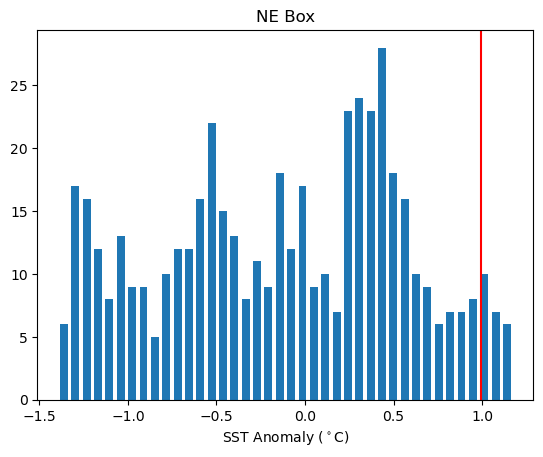

In [19]:
ne_plt, ne_ax = plt.subplots()
ne_roll.plot.hist(ax=ne_ax, bins=40, rwidth=0.7)
ne_ax.set_title("NE Box")
# red line represents 2020-2023 max anomaly
ne_ax.axvline(ne_roll.sel(time=slice("2020-01-01","2024-01-01")).max() , color = "red")
ne_ax.set_xlabel('SST Anomaly ($^\circ$C)')

<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/2801583881.py:6: SyntaxWarning: invalid escape sequence '\c'
  se_ax.set_xlabel('SST Anomaly ($^\circ$C)')


Text(0.5, 0, 'SST Anomaly ($^\\circ$C)')

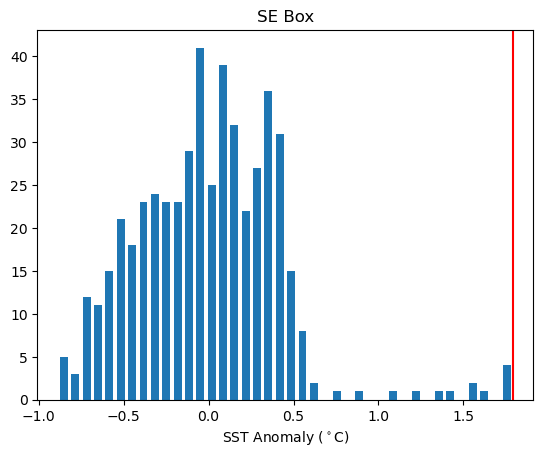

In [20]:
se_plt, se_ax = plt.subplots()
se_roll.plot.hist(ax=se_ax, bins=40, rwidth=0.7)
se_ax.set_title("SE Box")
# red line represents 2020-2023 max anomaly
se_ax.axvline(se_roll.sel(time=slice("2020-01-01","2024-01-01")).max(), color = "red")
se_ax.set_xlabel('SST Anomaly ($^\circ$C)')

<>:6: SyntaxWarning: invalid escape sequence '\c'
<>:6: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/2434814694.py:6: SyntaxWarning: invalid escape sequence '\c'
  sw_ax.set_xlabel('SST Anomaly ($^\circ$C)')


Text(0.5, 0, 'SST Anomaly ($^\\circ$C)')

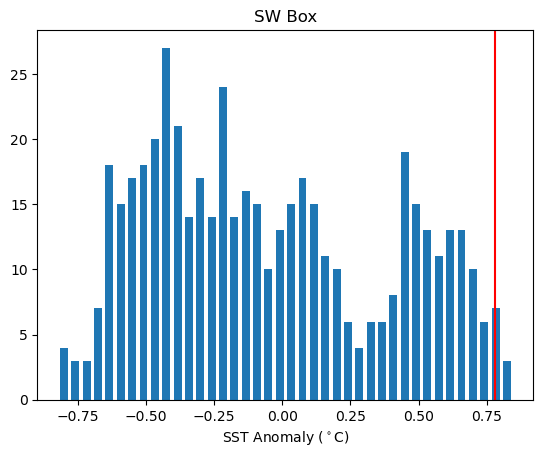

In [21]:
sw_plt, sw_ax = plt.subplots()
sw_roll.plot.hist(bins=40, rwidth=0.7)
sw_ax.set_title("SW Box")
# red line represents 2020-2023 max anomaly
sw_ax.axvline(sw_roll.sel(time=slice("2020-01-01","2024-01-01")).max(), color = "red")
sw_ax.set_xlabel('SST Anomaly ($^\circ$C)')

# NAO Correlation

In [22]:
# 12 month rolling average means that 2023-11-01 is the last date we have an index for
nao83to23 = nao_smooth.sel(time=slice("1983-01-01", "2023-11-01"))
nw83to23 = nw_roll.sel(time=slice("1983-01-01", "2023-11-01"))
# Calculate correlation of the two time series
nao_corr_nw = scipy.stats.pearsonr(nao83to23, nw83to23)
print(nao_corr_nw)

PearsonRResult(statistic=-0.5772823079120019, pvalue=5.650778429418957e-45)


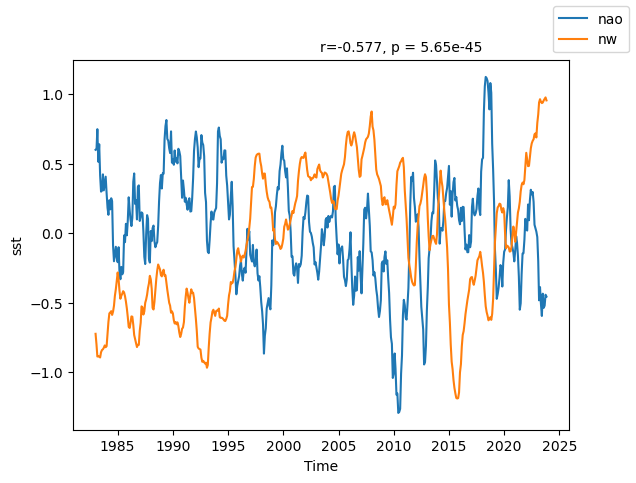

In [23]:
# Plot the NAO and NW box time serie for comparison
corr_plt, ax_corr = plt.subplots()
nao83to23.plot(ax=ax_corr, label="nao")
nw83to23.plot(ax=ax_corr, label="nw")
corr_plt.legend()
# Add statistics to the figure
ax_corr.annotate("r=-0.577, p = 5.65e-45", xy=(0.5,0.9), xycoords="figure fraction")
plt.savefig("figures/nw_correlation.png", dpi=300)

In [24]:
# Calculate correlation of the two time series
se83to23 = se_roll.sel(time=slice("1983-01-01", "2023-11-01"))
nao_corr_se = scipy.stats.pearsonr(nao83to23, se83to23)
print(nao_corr_se)

PearsonRResult(statistic=-0.40841838785802553, pvalue=3.6654737599075954e-21)


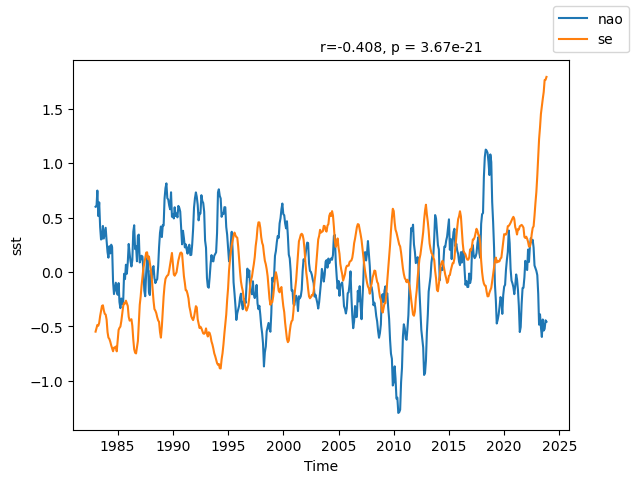

In [25]:
# Plot the NAO and NW box time serie for comparison
corr_plt, ax_corr = plt.subplots()
nao83to23.plot(ax=ax_corr, label="nao")
se83to23.plot(ax=ax_corr, label="se")
corr_plt.legend()
# Add statistics to the figure
ax_corr.annotate("r=-0.408, p = 3.67e-21", xy=(0.5,0.9), xycoords="figure fraction")
plt.savefig("figures/se_correlation.png", dpi=300)

# Decomposition

In [26]:
# Create DataFrame containing monthly mean SSTs
raw_ssts = ssts  #- climatology.mean(dim="time")
raw_ssts_ts = raw_ssts.sst.mean(['lat','lon'])
raw_ssts_smth = raw_ssts_ts.resample(time="1MS").mean(dim="time")
df_ssts = raw_ssts_smth.dropna(dim="time").to_pandas()

<>:19: SyntaxWarning: invalid escape sequence '\c'
<>:19: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/2933218941.py:19: SyntaxWarning: invalid escape sequence '\c'
  decomp_plt.supylabel("SST ($\circ$C)")


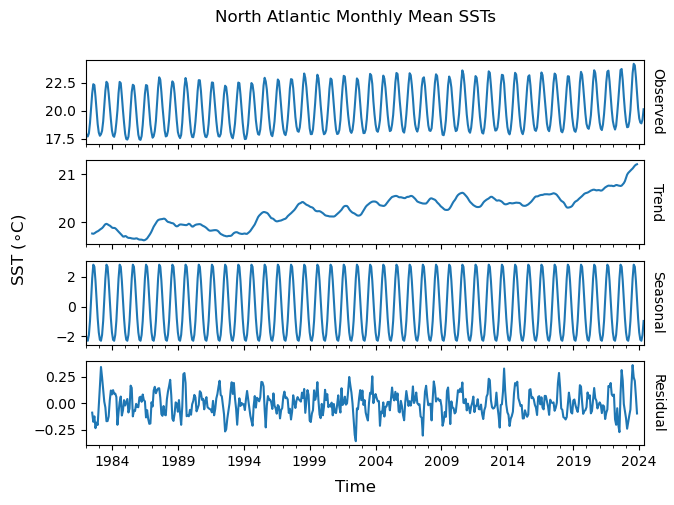

In [27]:
# Decompose North Atlantic SST time series using a naive additive model
na_decomp = decomp.seasonal_decompose(df_ssts, model="additive")
decomp_plt, axes_decomp = plt.subplots(4, 1, sharex=True, figsize=(7.2, 5))
na_decomp.observed.plot(ax=axes_decomp[0])
axes_decomp[0].set_ylabel("Observed", rotation=270, labelpad=15)
na_decomp.trend.plot(ax=axes_decomp[1])
axes_decomp[1].set_ylabel("Trend", rotation=270, labelpad=15)
na_decomp.seasonal.plot(ax=axes_decomp[2])
axes_decomp[2].set_ylabel("Seasonal", rotation=270, labelpad=15)
na_decomp.resid.plot(ax=axes_decomp[3])
axes_decomp[3].set_ylabel("Residual", rotation=270, labelpad=15)

# Remove subplots' x-axis labels from the figure
for ax in axes_decomp:
    ax.yaxis.set_label_position('right')
    ax.xaxis.label.set_visible(False)

# Set common x- and y-axis labels
decomp_plt.supylabel("SST ($\circ$C)")
decomp_plt.supxlabel("Time")
decomp_plt.suptitle("North Atlantic Monthly Mean SSTs")
plt.savefig("figures/NA_decomp.png", dpi=300)

<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:20: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/3685376540.py:20: SyntaxWarning: invalid escape sequence '\c'
  decomp_plt.supylabel("SST ($\circ$C)")


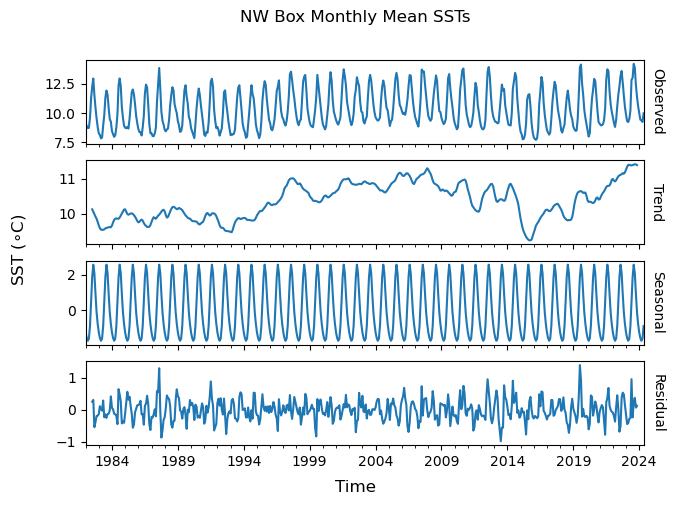

In [28]:
# Decompose NW BOX SST time series using a naive additive model
df_nw = ssts.sel(lon=slice(-25,-20), lat=slice(55, 60)).resample(time="1MS").mean(dim='time').mean(['lat','lon']).dropna(dim="time").to_pandas()
nw_decomp = decomp.seasonal_decompose(df_nw, model="additive")
decomp_plt, axes_decomp = plt.subplots(4, 1, sharex=True, figsize=(7.2, 5))
nw_decomp.observed.plot(ax=axes_decomp[0])
axes_decomp[0].set_ylabel("Observed", rotation=270, labelpad=15)
nw_decomp.trend.plot(ax=axes_decomp[1])
axes_decomp[1].set_ylabel("Trend", rotation=270, labelpad=15)
nw_decomp.seasonal.plot(ax=axes_decomp[2])
axes_decomp[2].set_ylabel("Seasonal", rotation=270, labelpad=15)
nw_decomp.resid.plot(ax=axes_decomp[3])
axes_decomp[3].set_ylabel("Residual", rotation=270, labelpad=15)

# Remove subplots' x-axis labels from the figure
for ax in axes_decomp:
    ax.yaxis.set_label_position('right')
    ax.xaxis.label.set_visible(False)

# Set common x- and y-axis labels
decomp_plt.supylabel("SST ($\circ$C)")
decomp_plt.supxlabel("Time")
decomp_plt.suptitle("NW Box Monthly Mean SSTs")
plt.savefig("figures/NW_decomp.png", dpi=300)

<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:20: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/259644459.py:20: SyntaxWarning: invalid escape sequence '\c'
  decomp_plt.supylabel("SST ($\circ$C)")


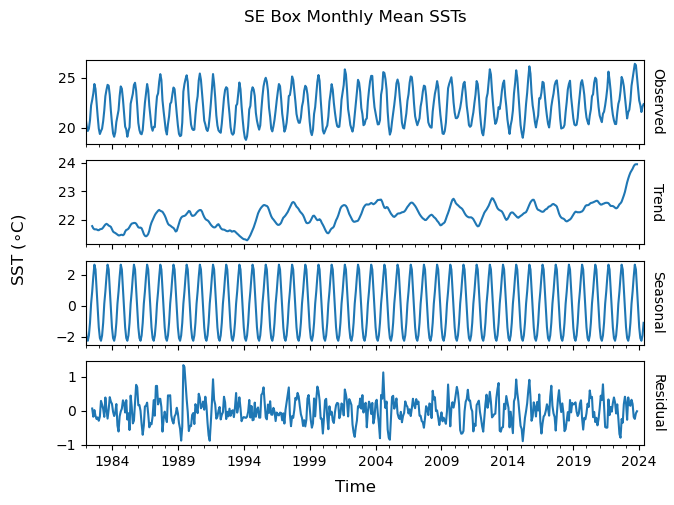

In [29]:
# Decompose SE BOX SST time series using a naive additive model
df_se = ssts.sel(lon=slice(-25,-20), lat=slice(25, 30)).resample(time="1MS").mean(dim='time').mean(['lat','lon']).dropna(dim="time").to_pandas()
se_decomp = decomp.seasonal_decompose(df_se, model="additive")
decomp_plt, axes_decomp = plt.subplots(4, 1, sharex=True, figsize=(7.2, 5))
se_decomp.observed.plot(ax=axes_decomp[0])
axes_decomp[0].set_ylabel("Observed", rotation=270, labelpad=15)
se_decomp.trend.plot(ax=axes_decomp[1])
axes_decomp[1].set_ylabel("Trend", rotation=270, labelpad=15)
se_decomp.seasonal.plot(ax=axes_decomp[2])
axes_decomp[2].set_ylabel("Seasonal", rotation=270, labelpad=15)
se_decomp.resid.plot(ax=axes_decomp[3])
axes_decomp[3].set_ylabel("Residual", rotation=270, labelpad=15)

# Remove subplots' x-axis labels from the figure
for ax in axes_decomp:
    ax.yaxis.set_label_position('right')
    ax.xaxis.label.set_visible(False)

# Set common x- and y-axis labels
decomp_plt.supylabel("SST ($\circ$C)")
decomp_plt.supxlabel("Time")
decomp_plt.suptitle("SE Box Monthly Mean SSTs")
plt.savefig("figures/SE_decomp.png", dpi=300)

<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:20: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/4183046988.py:20: SyntaxWarning: invalid escape sequence '\c'
  decomp_plt.supylabel("SST ($\circ$C)")


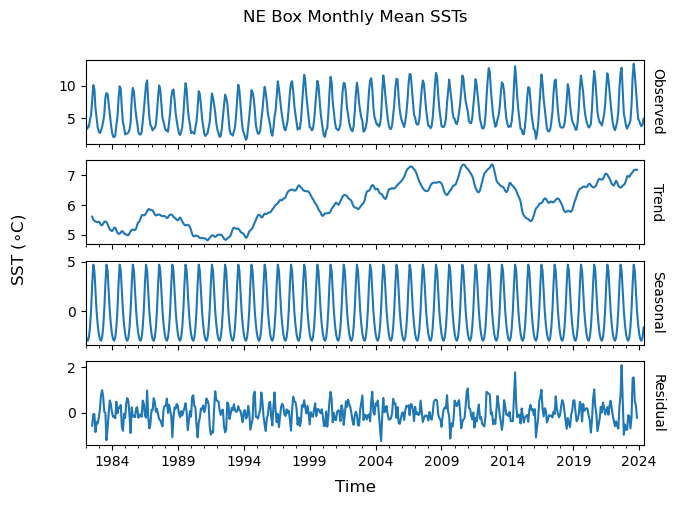

In [30]:
# Decompose NE BOX SST time series using a naive additive model
df_ne = ssts.sel(lon=slice(-51,-46), lat=slice(50, 55)).resample(time="1MS").mean(dim='time').mean(['lat','lon']).dropna(dim="time").to_pandas()
ne_decomp = decomp.seasonal_decompose(df_ne, model="additive")
decomp_plt, axes_decomp = plt.subplots(4, 1, sharex=True, figsize=(7.2, 5))
ne_decomp.observed.plot(ax=axes_decomp[0])
axes_decomp[0].set_ylabel("Observed", rotation=270, labelpad=15)
ne_decomp.trend.plot(ax=axes_decomp[1])
axes_decomp[1].set_ylabel("Trend", rotation=270, labelpad=15)
ne_decomp.seasonal.plot(ax=axes_decomp[2])
axes_decomp[2].set_ylabel("Seasonal", rotation=270, labelpad=15)
ne_decomp.resid.plot(ax=axes_decomp[3])
axes_decomp[3].set_ylabel("Residual", rotation=270, labelpad=15)

# Remove subplots' x-axis labels from the figure
for ax in axes_decomp:
    ax.yaxis.set_label_position('right')
    ax.xaxis.label.set_visible(False)

# Set common x- and y-axis labels
decomp_plt.supylabel("SST ($\circ$C)")
decomp_plt.supxlabel("Time")
decomp_plt.suptitle("NE Box Monthly Mean SSTs")
plt.savefig("figures/NE_decomp.png", dpi=300)

<>:20: SyntaxWarning: invalid escape sequence '\c'
<>:20: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_3084733/3216690977.py:20: SyntaxWarning: invalid escape sequence '\c'
  decomp_plt.supylabel("SST ($\circ$C)")


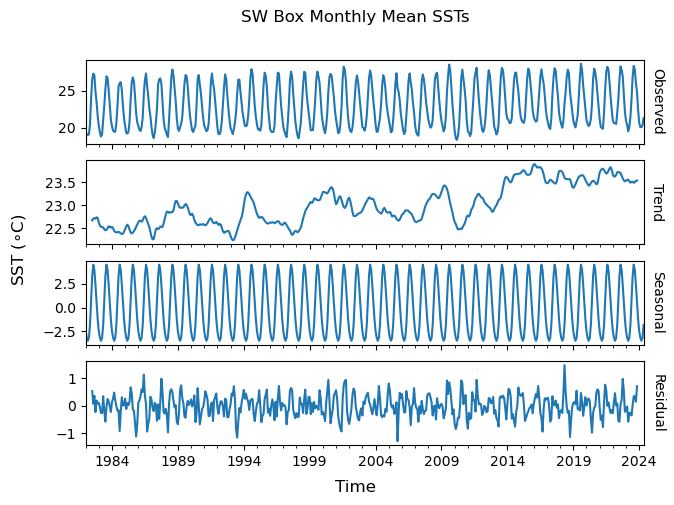

In [31]:
# Decompose SW BOX SST time series using a naive additive model
df_sw = ssts.sel(lon=slice(-55,-50), lat=slice(30, 35)).resample(time="1MS").mean(dim='time').mean(['lat','lon']).dropna(dim="time").to_pandas()
sw_decomp = decomp.seasonal_decompose(df_sw, model="additive")
decomp_plt, axes_decomp = plt.subplots(4, 1, sharex=True, figsize=(7.2, 5))
sw_decomp.observed.plot(ax=axes_decomp[0])
axes_decomp[0].set_ylabel("Observed", rotation=270, labelpad=15)
sw_decomp.trend.plot(ax=axes_decomp[1])
axes_decomp[1].set_ylabel("Trend", rotation=270, labelpad=15)
sw_decomp.seasonal.plot(ax=axes_decomp[2])
axes_decomp[2].set_ylabel("Seasonal", rotation=270, labelpad=15)
sw_decomp.resid.plot(ax=axes_decomp[3])
axes_decomp[3].set_ylabel("Residual", rotation=270, labelpad=15)

# Remove subplots' x-axis labels from the figure
for ax in axes_decomp:
    ax.yaxis.set_label_position('right')
    ax.xaxis.label.set_visible(False)

# Set common x- and y-axis labels
decomp_plt.supylabel("SST ($\circ$C)")
decomp_plt.supxlabel("Time")
decomp_plt.suptitle("SW Box Monthly Mean SSTs")
plt.savefig("figures/SW_decomp.png", dpi=300)